In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
import skimage
from skimage.feature import blob_log


Range of  2 - 40  sigma values are used.
The maximum estimated standard deviation:  50.91168824543143


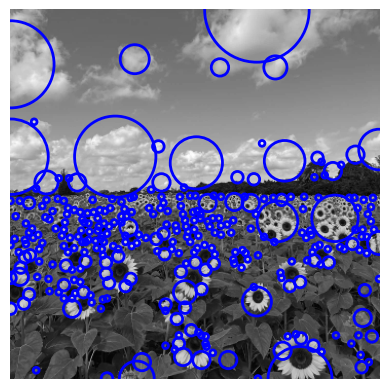

In [5]:
# Loading the image
img_orig = cv.imread("Images/New folder/the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)
img_gray = cv.cvtColor(img_orig, cv.COLOR_BGR2GRAY)

blobs = blob_log(img_gray, min_sigma=2, max_sigma=40, num_sigma=20, threshold=.1)
a = max(blobs[:, 2])
blobs[:, 2] = blobs[:, 2] * math.sqrt(2)
b = max(blobs[:, 2])

fig, ax = plt.subplots()
ax.imshow(img_gray, cmap='gray')
ax.axis('off')

for b in blobs:
    y, x, r = b
    c = plt.Circle((x, y), r, color='blue', linewidth=2, fill=False)
    ax.add_patch(c)
    

print('Range of ', 2, '-', 40, ' sigma values are used.')    
print('The maximum estimated standard deviation: ', max(blobs[:, 2]))

plt.show()

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def laplacian_of_gaussian(img_gray, sigma):
    """Applies Laplacian of Gaussian to the image."""
    # Apply Gaussian blur
    blur = cv.GaussianBlur(img_gray, (0, 0), sigma)
    # Compute Laplacian
    laplacian = cv.Laplacian(blur, cv.CV_64F)
    return laplacian

def detect_blobs_log(img_gray, min_sigma=2, max_sigma=30, num_sigma=10, threshold=0.03):
    """Detect blobs using the Laplacian of Gaussian (LoG) and scale-space extrema detection."""
    sigma_values = np.linspace(min_sigma, max_sigma, num_sigma)
    blobs = []

    for sigma in sigma_values:
        # Get Laplacian of Gaussian
        log_image = laplacian_of_gaussian(img_gray, sigma)
        # Normalize and threshold
        log_image = (log_image - log_image.min()) / (log_image.max() - log_image.min())
        log_image = np.where(log_image > threshold, log_image, 0)

        # Find local maxima
        keypoints = np.argwhere(log_image > 0)
        for keypoint in keypoints:
            y, x = keypoint
            blobs.append((y, x, sigma))
    
    return blobs

# Load the image and convert to grayscale
img_orig = cv.imread("Images/New folder/the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)
img_gray = cv.cvtColor(img_orig, cv.COLOR_BGR2GRAY)

# Detect blobs using LoG and scale-space extrema detection
blobs = detect_blobs_log(img_gray)

# Plot the image and the detected blobs as circles
fig, ax = plt.subplots()
ax.imshow(img_gray, cmap='gray')
ax.axis('off')

# Draw circles on the detected blobs
for blob in blobs:
    y, x, sigma = blob
    radius = sigma * np.sqrt(2)
    c = plt.Circle((x, y), radius, color='blue', linewidth=2, fill=False)
    ax.add_patch(c)

# Show the final image with circles
plt.show()

# Print the maximum sigma (blob size) detected
if blobs:
    max_sigma = max([blob[2] for blob in blobs])
    print('The maximum estimated standard deviation (sigma):', max_sigma)
else:
    print('No blobs detected.')


KeyboardInterrupt: 


Iteration:  6
Best line error:  8.960005151024731
Best sample indices for line:  [72 51]
Best line model:  [0.70741517 0.70679829 1.62539579]
Total inliers:  56

Iteration:  13
Best line error:  5.655263434618127
Best sample indices for line:  [81 34]
Best line model:  [0.69966588 0.71447019 1.67346701]
Total inliers:  49

----------------------------------- Circle Estimation -----------------------------------
Number of inliers for line model:  49
Number of points remaining for circle estimation:  51

Iteration:  100
Best circle error:  6.395132351467394
Best circle sample indices:  [34 44  9]
Best circle model:  [ 2.02102968  3.08371089 10.21952505]
Total inliers:  39

Iteration:  100
Best circle error:  5.5469057906115085
Best circle sample indices:  [43 23 46]
Best circle model:  [ 1.99028945  3.10920165 10.23920132]
Total inliers:  38


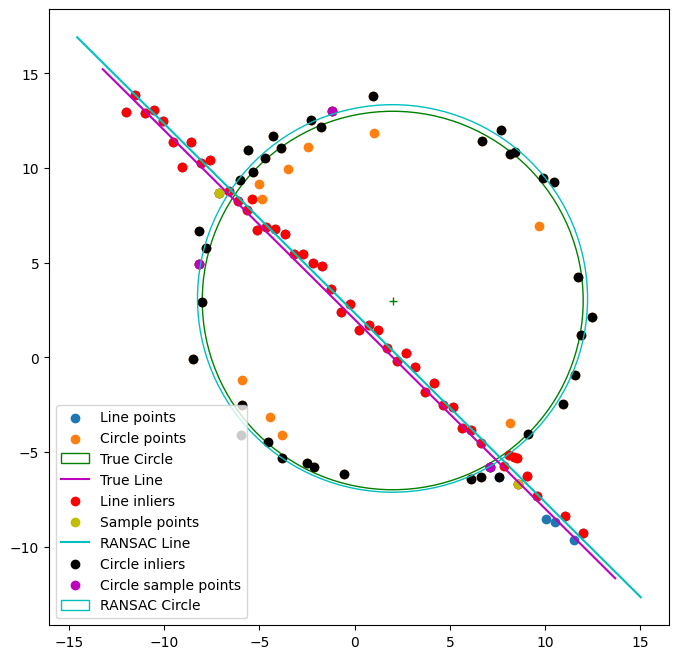

In [6]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Set up the parameters
total_points = 100
half_points = total_points // 2

circle_radius = 10
center_x, center_y = 2, 3  # Circle center
noise_scale = circle_radius / 16

# Generate noisy points on the circle
angle = np.random.uniform(0, 2 * np.pi, half_points)
noise = noise_scale * np.random.randn(half_points)
x_circle = center_x + (circle_radius + noise) * np.cos(angle)
y_circle = center_y + (circle_radius + noise) * np.sin(angle)
circle_points = np.hstack((x_circle.reshape(half_points, 1), y_circle.reshape(half_points, 1)))

# Generate noisy points on the line
line_slope, line_intercept = -1, 2
x_line = np.linspace(-12, 12, half_points)
y_line = line_slope * x_line + line_intercept + noise_scale * np.random.randn(half_points)
line_points = np.hstack((x_line.reshape(half_points, 1), y_line.reshape(half_points, 1)))

# Combine circle and line points
all_points = np.vstack((circle_points, line_points))

# Plot the points and ground truth models
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(line_points[:, 0], line_points[:, 1], label='Line points')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle points')

# Plot ground truth circle and line
true_circle = plt.Circle((center_x, center_y), circle_radius, color='g', fill=False, label='True Circle')
ax.add_patch(true_circle)
ax.plot(center_x, center_y, '+', color='g')
x_min, x_max = ax.get_xlim()
x_vals = np.array([x_min, x_max])
y_vals = line_slope * x_vals + line_intercept
ax.plot(x_vals, y_vals, color='m', label='True Line')
ax.legend()

# Line estimation using RANSAC
def line_constraint(params):
    # Constraint for the line: equation of the line
    return (params[0] ** 2) + (params[1] ** 2) - 1

line_cons = ({'type': 'eq', 'fun': line_constraint})

def line_lse_error(params, indices):
    # Compute total least square error for a line
    a, b, c = params[0], params[1], params[2]
    error = np.square(a * all_points[indices, 0] + b * all_points[indices, 1] - c)
    return np.sum(error)

def line_consensus_set(all_points, params, threshold):
    # Find consensus set for the line
    a, b, c = params[0], params[1], params[2]
    error = np.abs(a * all_points[:, 0] + b * all_points[:, 1] - c)
    return error < threshold

# RANSAC parameters for line estimation
max_iter = 100
line_inliers_needed = 0.4 * total_points
line_threshold = 1.0
best_line_error = np.inf
line_sample_size = 2
iteration_count = 0

best_line_model = []
best_line_inliers = []
best_line_sample_indices = []

while iteration_count < max_iter:
    # Randomly sample points for line estimation
    line_sample_indices = np.random.randint(0, total_points, line_sample_size)

    # Initial guess for the model
    initial_guess = np.array([1, 1, 0])
    # Minimize the least squares error
    result = minimize(line_lse_error, initial_guess, args=(line_sample_indices), tol=1e-6, constraints=line_cons)
    # Get consensus set
    line_inliers = line_consensus_set(all_points, result.x, line_threshold)

    if np.sum(line_inliers) > line_inliers_needed:
        initial_guess = result.x
        # Refit the model using the consensus inliers
        result = minimize(line_lse_error, initial_guess, args=(line_inliers), tol=1e-6, constraints=line_cons)

        if result.fun < best_line_error:
            print('\nIteration: ', iteration_count)
            best_line_error = result.fun
            best_line_sample_indices = line_sample_indices
            best_line_model = result.x
            best_line_inliers = line_inliers

            print('Best line error: ', result.fun)
            print('Best sample indices for line: ', line_sample_indices)
            print('Best line model: ', result.x)
            print('Total inliers: ', np.sum(line_inliers))

    iteration_count += 1

# Plot the RANSAC results for the line
ax.scatter(all_points[best_line_inliers, 0], all_points[best_line_inliers, 1], color='r', label='Line inliers')
ax.scatter(all_points[line_sample_indices, 0], all_points[line_sample_indices, 1], color='y', label='Sample points')
x_min, x_max = ax.get_xlim()
x_vals = np.array([x_min, x_max])
y_vals = (-best_line_model[1] * x_vals + best_line_model[2]) / best_line_model[1]
ax.plot(x_vals, y_vals, color='c', label='RANSAC Line')
ax.legend()

# Circle estimation using RANSAC
print('\n----------------------------------- Circle Estimation -----------------------------------')
print('Number of inliers for line model: ', np.sum(best_line_inliers))

# Find outliers from the line model to estimate the circle
line_outliers = np.where(best_line_inliers == False)[0]
remnant_points = np.array([all_points[line_outliers[i]] for i in range(len(line_outliers))])
print('Number of points remaining for circle estimation: ', len(remnant_points))

def circle_lse_error(params, indices):
    # Total least square error for a circle
    center_x, center_y, radius = params
    x_points, y_points = remnant_points[indices].T
    error = (np.sqrt((x_points - center_x) ** 2 + (y_points - center_y) ** 2) - radius) ** 2
    return np.sum(error)

def circle_consensus_set(remnant_points, params, threshold):
    distances = np.abs(np.linalg.norm(remnant_points - params[:2], axis=1) - params[2])
    return distances < threshold

# RANSAC parameters for circle estimation
circle_threshold = 1.0
max_iter = 100
best_circle_model = []
best_circle_inliers = []
best_circle_sample_indices = []

best_circle_error = np.inf
circle_sample_size = 3
min_inliers_for_circle = 35
i=0

while i < max_iter:
    circle_sample_indices = np.random.randint(0, len(remnant_points), circle_sample_size)

    # Initial guess for the circle model
    initial_guess = np.array([0, 0, 0])
    # Minimize the error
    result = minimize(circle_lse_error, initial_guess, args=(circle_sample_indices), tol=1e-6)
    # Get consensus set for the circle
    circle_inliers = circle_consensus_set(remnant_points, result.x, circle_threshold)

    if np.sum(circle_inliers) > min_inliers_for_circle:
        initial_guess = result.x
        # Refit the model using the consensus inliers
        result = minimize(circle_lse_error, initial_guess, args=(circle_inliers), tol=1e-6)

        if result.fun < best_circle_error:
            print('\nIteration: ', iteration_count)
            best_circle_error = result.fun
            best_circle_sample_indices = circle_sample_indices
            best_circle_model = result.x
            best_circle_inliers = circle_inliers

            print('Best circle error: ', best_circle_error)
            print('Best circle sample indices: ', best_circle_sample_indices)
            print('Best circle model: ', best_circle_model)
            print('Total inliers: ', np.sum(best_circle_inliers))

    i += 1

# Plot the RANSAC results for the circle
ax.scatter(remnant_points[best_circle_inliers, 0], remnant_points[best_circle_inliers, 1], color='k', label='Circle inliers')
ax.scatter(remnant_points[best_circle_sample_indices, 0], remnant_points[best_circle_sample_indices, 1], color='m', label='Circle sample points')
circle_estimate = plt.Circle((best_circle_model[0], best_circle_model[1]), best_circle_model[2], color='c', fill=False, label='RANSAC Circle')
ax.add_patch(circle_estimate)
ax.legend()

# Save the figure to file
plt.savefig('circle_and_line_ransac.png')  # Save plot as PNG

# Show the plot
plt.show()


In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def point_selection(action, x, y, flags, param):
    # Define mouse click occasions to gather point coordinates for warping the image
    global clicked_points

    if action == cv.EVENT_LBUTTONDOWN:
        clicked_points.append((x, y))
        cv.circle(base_img, (x, y), 4, (0, 0, 255), -1)
        
        # Show the selected positions on the base image in a second window
        # (Simply close this second window and continue point selection in the first window)
        cv.imshow('Image', base_img)

base_img = cv.imread('Images/New folder/005.jpg')
adding_img = cv.imread('Images/New folder/flag.png')

# Normalize the pixel values into [0, 1] range
base_img = base_img.astype(np.float32) / np.iinfo(base_img.dtype).max
adding_img = adding_img.astype(np.float32) / np.iinfo(adding_img.dtype).max

# Display the base image to implement point selection step
cv.imshow('Base Image', base_img)
cv.setMouseCallback('Base Image', point_selection)

# Store the clicked points in the image
clicked_points = []

# Point Selection Step
# Select four points in the order of left top, left bottom, right top, and right bottom
while len(clicked_points) < 4:
    cv.waitKey(1)
cv.destroyAllWindows()

# Define source and destination points for homography
destination_points = np.array(clicked_points).astype(np.float32)
h2, w2 = adding_img.shape[:2]
source_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

# Define the homographic matrix
H = cv.getPerspectiveTransform(source_points, destination_points)

# Warping the adding image with the homography
warped_img = cv.warpPerspective(adding_img, H, (base_img.shape[1], base_img.shape[0]))

# Superimposing the warped image with the base image
supimp_img = cv.addWeighted(base_img, 1, warped_img, 0.5, 0)

#region
print("Image shape:", base_img.shape)
print("Flag shape:", adding_img.shape)
print("Selected Points:", clicked_points)
print('Homographic Matrix: ')
print(H)
#endregion

# Plotting the final output image with proper scaling to [0, 255] range
plt.figure(figsize=(12,6))
plt.imshow(cv.cvtColor((supimp_img * 255).astype(np.uint8), cv.COLOR_BGR2RGB))  # Rescaling back to [0, 255]
plt.title('Image of a Building Superimposed with the United Kingdom Flag')
plt.axis('off')  # Hide axes
plt.show()


KeyboardInterrupt: 

Image shape: (768, 1024, 3)
Flag shape: (960, 1920, 3)
Selected Points: [(387, 359), (293, 333), (281, 456), (396, 480)]
Homographic Matrix: 
[[-5.67191217e-02 -6.29049675e-01  3.87000000e+02]
 [-2.23619483e-02 -7.40583429e-01  3.59000000e+02]
 [-2.64873323e-05 -1.84566907e-03  1.00000000e+00]]


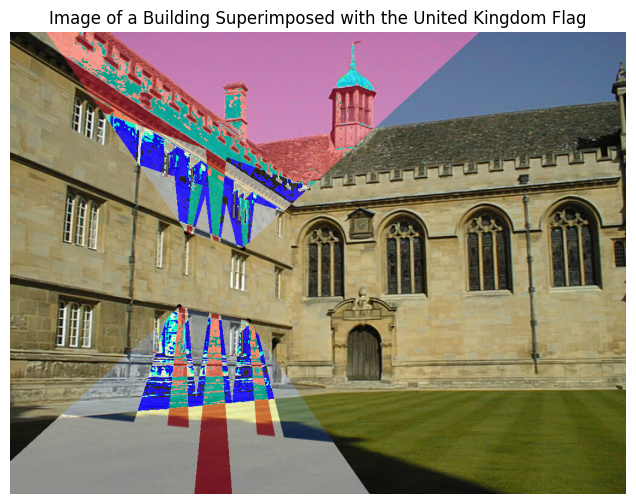

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def point_selection(action, x, y, flags, param):
    # Define mouse click occasions to gather point coordinates for warping the image
    global clicked_points

    if action == cv.EVENT_LBUTTONDOWN:
        clicked_points.append((x, y))
        cv.circle(base_img, (x, y), 4, (0, 0, 255), -1)
        
        # Show the selected positions on the base image in a second window
        # (Simply close this second window and continue point selection in the first window)
        cv.imshow('Base Image', base_img)

base_img = cv.imread('Images/New folder/005.jpg')
adding_img = cv.imread('Images/New folder/flag.png')

# Normalize the pixel values into [0, 1] range
base_img = base_img.astype(np.float32) / np.iinfo(base_img.dtype).max
adding_img = adding_img.astype(np.float32) / np.iinfo(adding_img.dtype).max

# Display the base image to implement point selection step
cv.imshow('Base Image', base_img)
cv.setMouseCallback('Base Image', point_selection)

# Store the clicked points in the image
clicked_points = []

# Point Selection Step
# Select four points in the order of left top, left bottom, right top, and right bottom
while len(clicked_points) < 4:
    cv.waitKey(1)  # Make sure this is continuously running and waiting for input
cv.destroyAllWindows()

# Define source and destination points for homography
destination_points = np.array(clicked_points).astype(np.float32)
h2, w2 = adding_img.shape[:2]
source_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

# Define the homographic matrix
H = cv.getPerspectiveTransform(source_points, destination_points)

# Warping the adding image with the homography
warped_img = cv.warpPerspective(adding_img, H, (base_img.shape[1], base_img.shape[0]))

# Superimposing the warped image with the base image
supimp_img = cv.addWeighted(base_img, 1, warped_img, 0.5, 0)

#region
print("Image shape:", base_img.shape)
print("Flag shape:", adding_img.shape)
print("Selected Points:", clicked_points)
print('Homographic Matrix: ')
print(H)
#endregion

# Plotting the final output image with proper scaling to [0, 255] range
plt.figure(figsize=(12,6))
plt.imshow(cv.cvtColor((supimp_img * 255).astype(np.uint8), cv.COLOR_BGR2RGB))  # Rescaling back to [0, 255]
plt.title('Image of a Building Superimposed with the United Kingdom Flag')
plt.axis('off')  # Hide axes
plt.show()


Image shape: (768, 1024, 3)
Flag shape: (960, 1920, 3)
Selected Points: [(238, 303), (372, 353), (371, 474), (237, 452)]
Homographic Matrix: 
[[ 1.14565626e-01 -7.24348670e-01  2.38000000e+02]
 [ 6.85287838e-02 -9.24327882e-01  3.03000000e+02]
 [ 1.20360105e-04 -2.32584996e-03  1.00000000e+00]]


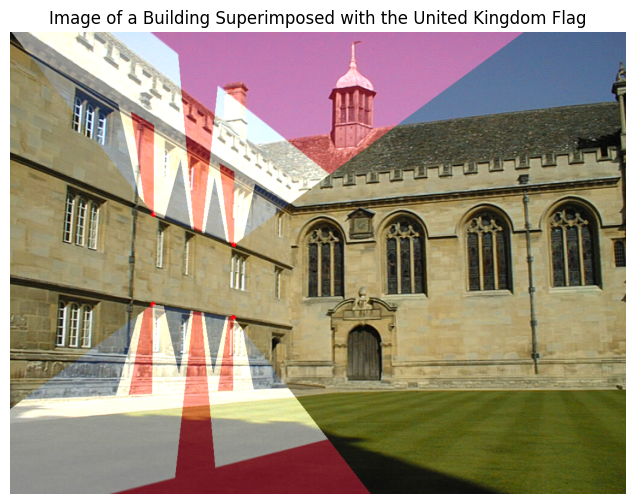

In [10]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def point_selection(action, x, y, flags, param):
    # Define mouse click occasions to gather point coordinates for warping the image
    global clicked_points

    if action == cv.EVENT_LBUTTONDOWN:
        clicked_points.append((x, y))
        cv.circle(base_img, (x, y), 4, (0, 0, 255), -1)
        
        # Show the selected positions on the base image in a second window
        # (Simply close this second window and continue point selection in the first window)
        cv.imshow('Base Image', base_img)

base_img = cv.imread('Images/New folder/005.jpg')
adding_img = cv.imread('Images/New folder/flag.png')

# Display the base image to implement point selection step
cv.imshow('Base Image', base_img)
cv.setMouseCallback('Base Image', point_selection)

# Store the clicked points in the image
clicked_points = []

# Point Selection Step
# Select four points in the order of left top, left bottom, right top, and right bottom
while len(clicked_points) < 4:
    cv.waitKey(1)  # Make sure this is continuously running and waiting for input
cv.destroyAllWindows()

# Define source and destination points for homography
destination_points = np.array(clicked_points).astype(np.float32)
h2, w2 = adding_img.shape[:2]
source_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

# Define the homographic matrix
H = cv.getPerspectiveTransform(source_points, destination_points)

# Warping the adding image with the homography
warped_img = cv.warpPerspective(adding_img, H, (base_img.shape[1], base_img.shape[0]))

# Adjust opacity by blending the images with cv.addWeighted (no color distortion)
opacity = 0.5  # Change this value to adjust opacity of the flag
supimp_img = cv.addWeighted(base_img, 1, warped_img, opacity, 0)

#region
print("Image shape:", base_img.shape)
print("Flag shape:", adding_img.shape)
print("Selected Points:", clicked_points)
print('Homographic Matrix: ')
print(H)
#endregion

# Plotting the final output image with proper scaling to [0, 255] range
plt.figure(figsize=(12,6))
plt.imshow(cv.cvtColor(supimp_img, cv.COLOR_BGR2RGB))  # No need to rescale, we're working in [0, 255]
plt.title('Image of a Building Superimposed with the United Kingdom Flag')
plt.axis('off')  # Hide axes
plt.show()


Image shape: (768, 1024, 3)
Flag shape: (960, 1920, 3)
Selected Points: [(235, 304), (383, 357), (385, 480), (242, 454)]
Homographic Matrix: 
[[ 1.19522563e-01 -7.43984148e-01  2.35000000e+02]
 [ 6.71624043e-02 -9.39036513e-01  3.04000000e+02]
 [ 1.10807388e-04 -2.33827051e-03  1.00000000e+00]]


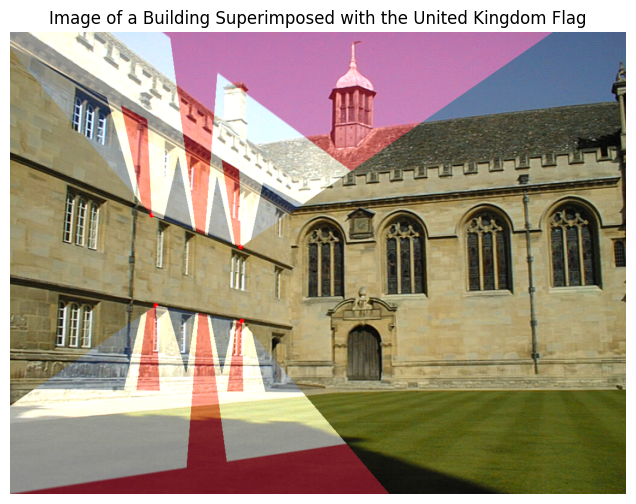

In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def point_selection(action, x, y, flags, param):
    # Define mouse click occasions to gather point coordinates for warping the image
    global clicked_points

    if action == cv.EVENT_LBUTTONDOWN:
        clicked_points.append((x, y))
        cv.circle(base_img, (x, y), 4, (0, 0, 255), -1)
        
        # Show the selected positions on the base image in a second window
        # (Simply close this second window and continue point selection in the first window)
        cv.imshow('Base Image', base_img)

base_img = cv.imread('Images/New folder/005.jpg')
adding_img = cv.imread('Images/New folder/flag.png')

# Display the base image to implement point selection step
cv.imshow('Base Image', base_img)
cv.setMouseCallback('Base Image', point_selection)

# Store the clicked points in the image
clicked_points = []

# Point Selection Step
# Select four points in the order of left top, left bottom, right top, and right bottom
while len(clicked_points) < 4:
    cv.waitKey(1)  # Make sure this is continuously running and waiting for input
cv.destroyAllWindows()

# Define source and destination points for homography
destination_points = np.array(clicked_points).astype(np.float32)
h2, w2 = adding_img.shape[:2]
source_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

# Define the homographic matrix
H = cv.getPerspectiveTransform(source_points, destination_points)

# Warping the adding image with the homography
warped_img = cv.warpPerspective(adding_img, H, (base_img.shape[1], base_img.shape[0]))

# Adjust opacity by blending the images with cv.addWeighted (no color distortion)
opacity = 0.5  # Change this value to adjust opacity of the flag
supimp_img = cv.addWeighted(base_img, 1, warped_img, opacity, 0)

#region
print("Image shape:", base_img.shape)
print("Flag shape:", adding_img.shape)
print("Selected Points:", clicked_points)
print('Homographic Matrix: ')
print(H)
#endregion

# Plotting the final output image with no color change
plt.figure(figsize=(12,6))
plt.imshow(cv.cvtColor(supimp_img, cv.COLOR_BGR2RGB))  # Final output (no normalization)
plt.title('Image of a Building Superimposed with the United Kingdom Flag')
plt.axis('off')  # Hide axes
plt.show()
